In [30]:
import numpy as np
from utils import Environment, GameDifficulty, Experiment
from policy import E_Greedy
import matplotlib.pyplot as plt
import os, pickle

In [31]:
# Simple train loop

def train(episode, env, lr, gamma, policy):
    reward_history = []
    for episode in range(episode):
        running_reward = []
        while not env.is_gameover:
            # choose action
            idx_action = policy.take_action(env.agent.current_location, env.q_values)
            # store previous coordinates of the agent
            prev_x, prev_y = env.agent.current_location
            # transition to next state and get immediate reward
            reward = env.step(idx_action)
            running_reward.append(reward)
            # get previous q-value
            prev_q_value = env.q_values[prev_x, prev_y, idx_action]
            # store updated agent location
            agent_x, agent_y = env.agent.current_location
            # compute temporal error difference
            t_d_error = reward + (gamma * np.max(env.q_values[agent_x, agent_y]) - prev_q_value)
            # update Q-value of the previous state-action pair.
            updated_q_value = prev_q_value + (lr * t_d_error)
            env.q_values[prev_x, prev_y, idx_action] = updated_q_value
        # at the end of each game store the average reward
        running_reward.append(env.final_reward)
        if episode % 500 == 0:
            avg_reward = np.mean(running_reward)
            reward_history.append(avg_reward)
        env.reset()
    return reward_history

In [32]:
exp_results = {}
save_path = os.path.join(os.curdir, 'saved_files/difficulty_comparison.pickle')

if os.path.exists(save_path):
    # load values
    with open(save_path, 'rb') as file2load:
        print('Loading previous values...')
        exp_results = pickle.load(file2load)
        print('Values Loaded')

else:
    os.rmdir(os.path.join(os.curdir, 'saved_files'))
    os.mkdir(os.path.join(os.curdir, 'saved_files'))
    episodes = 20000
    experiments = [Experiment(episodes=episodes, difficulty=GameDifficulty.EASY, gamma=0.96),
               Experiment(episodes=episodes, difficulty=GameDifficulty.HARD, gamma=0.96)]
    exp_results = {}
    for idx, exp in enumerate(experiments):
        history_rewards = []
        print('Beginning experiment [{}/{}] ...'.format(idx+1, len(experiments)))
        dim_batch = [10, 15, 20, 25]
        for dim in dim_batch:
            env = Environment(dimension=dim, difficulty=exp.difficulty)
            policy = E_Greedy(exp.epsilon)
            rewards = train(episode=exp.episodes, env=env, lr=exp.lr, gamma=exp.gamma, policy=policy)
            history_rewards.append(rewards)

        exp_results[exp.difficulty.name] = {'rewards': history_rewards, 'dim': dim_batch}
        print('Experiment [{}/{}] completed'.format(idx+1, len(experiments)))
    print('Training Completed')
    file_name = 'difficulty_comparison.pickle'
    print('Saving values...')
    with open(os.path.join(os.curdir, 'saved_files/'+file_name), 'wb') as file2store:
        pickle.dump(exp_results, file2store, protocol=pickle.HIGHEST_PROTOCOL)
    print('Done!')

Beginning experiment [1/2] ...
Experiment [1/2] completed
Beginning experiment [2/2] ...
Experiment [2/2] completed
Training Completed
Saving values...
Done!


In [33]:
def plot_image(exp_results, exp_name):
    n_experiments = len(exp_results[exp_name]['rewards'])
    dim = exp_results[exp_name]['dim']
    plt.figure(figsize=(10, 8))
    for i in range(n_experiments):
        plt.subplot(2, 2, i+1)
        plt.plot(exp_results[exp_name]['rewards'][i])
        plt.xscale('log')
        plt.xlabel('Reward Samples')
        plt.ylabel('Rewards')
        plt.title('{} Results, Dimension {}'.format(exp_name, dim[i]))

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

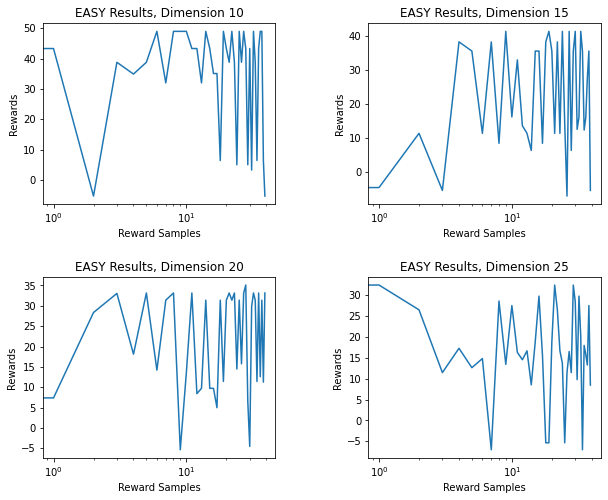

In [34]:
plot_image(exp_results, exp_name='EASY')

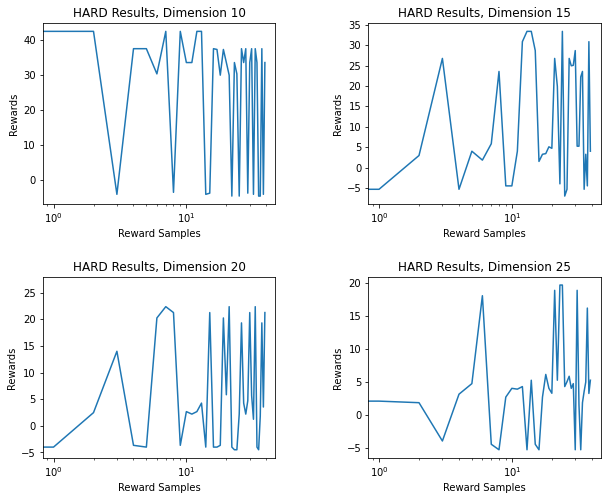

In [35]:
plot_image(exp_results, exp_name='HARD')

In [36]:
# Check how the reward behaves when the dimensions and the eps-values change
# Set an eps value and a dimension. Execute experiments, compute avg to see
# how different eps values affect rewards in different sizes.

# Hyperparameters
eps_values = [.01, .1, .2, .5]
dim=25
results = {}
gamma = .96
episodes = 20000
# in a stochastic environment we want the agent to learn little by little
# lr = 0 -> no learning
# lr = 1 -> learn only the most recent information
lr = .1

save_path = os.path.join(os.curdir, 'saved_files/eps_comparison.pickle')
if os.path.exists(save_path):
    # load values
    with open(save_path, 'rb') as file2load:
        results = pickle.load(file2load)
else:
    for idx, eps in enumerate(eps_values):
        print('Beginning experiment [{}/{}] ...'.format(idx+1, len(eps_values)))
        reward_history = []
        name_exp = 'Experiment {}'.format(idx+1)
        policy = E_Greedy(eps)
        env = Environment(dimension=dim, difficulty=GameDifficulty.EASY)
        rewards = train(episodes, env, lr=lr, gamma=gamma, policy=policy)
        reward_history.append(rewards)
        results[name_exp] = {'rewards': reward_history, 'eps': eps_values}
        print('Experiment [{}/{}] completed'.format(idx+1, len(eps_values)))
    file_name = 'eps_comparison.pickle'
    with open(os.path.join(os.curdir, 'saved_files/'+file_name), 'wb') as file2store:
        pickle.dump(results, file2store, protocol=pickle.HIGHEST_PROTOCOL)

Beginning experiment [1/4] ...
Experiment [1/4] completed
Beginning experiment [2/4] ...
Experiment [2/4] completed
Beginning experiment [3/4] ...
Experiment [3/4] completed
Beginning experiment [4/4] ...
Experiment [4/4] completed


In [37]:
def plot_eps(results):
    plt.figure(figsize=(10, 8))
    for idx, name in enumerate(results.keys()):
        data = results[name]['rewards'][0]
        eps = results[name]['eps'][idx]
        plt.subplot(2, 2, idx+1)
        plt.plot(data)
        plt.xscale('log')
        plt.xlabel('Reward Samples')
        plt.ylabel('Average Rewards')
        plt.title('{} Results, eps {}'.format(name, eps))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

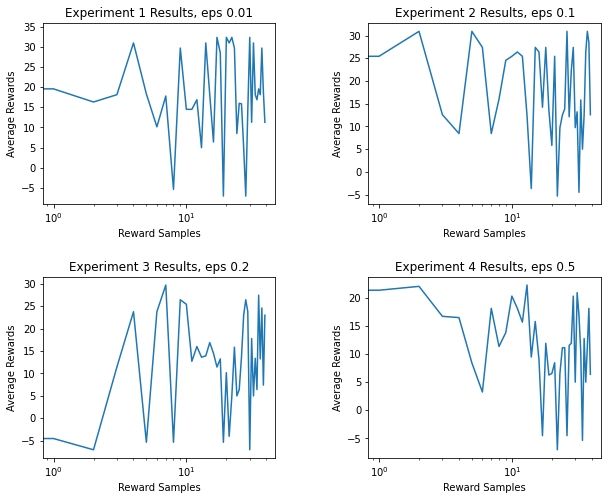

In [38]:
# plot rewards vs eps values.
plot_eps(results)